# Point cloud based surface defect detection and localisation

### Author: Chen Lequn
#### Initial commit: 13 Jan, 2021

## Project description and objectives:
- Preprocessing the point cloud data: 
1. data standarisation - centered at zero coordinate; 
2. Data labeling: add a fourth dimension to the dataset - marking all the points to "non-defective (flat)"; "machining (bulge)"; "AM repair (dent)"
- 3D shape fitting feature extraction:
1. calculating surface normal vector and principle curvatures.
2. Methdologies (candidate): PCA, Jet approximation, DeepFit Network (based on PointNet, ECCV 2020)
- Segmentation/Classification:
1. Automatic point cloud segmentation based on PointNet
2. Explore various point cloud classification/segmentation algorithms from recent years 2017-2021 CVPR/IROS 

## **Notebook 2 (c): cleaned up and faster computation version: point cloud shape fitting and feature extraction analysis**

## Introduction

This notebook aims to estimate normal vectors and principal curvatures from 3D point clouds using classic PCA and Jet fitting methods as well as recent DeepFit method. 


Surface normals and curvatures are a very important properties in shape analysis and are widely used in different fields like computer graphics, computer vision and more. 

Such features are useful for noise reduction, point cloud segmentation, and classification.


### Reference: 
- **DeepFit(ECCV 2020)** Network: 3D surface fitting https://github.com/sitzikbs/DeepFit
- **Nesti-Net**: Normal Estimation for Unstructured 3D Point Clouds using Convolutional Neural Networks: https://github.com/sitzikbs/Nesti-Net#nesti-net-normal-estimation-for-unstructured-3d-point-clouds-using-convolutional-neural-networks
* [PCL normal estimation using PCA](http://pointclouds.org/documentation/tutorials/normal_estimation.php)
* [CGAL normal estimation using Jets](https://doc.cgal.org/latest/Jet_fitting_3/index.html#Jet_fitting_3Mathematical)
* [DeepFit paper](https://arxiv.org/pdf/2003.10826.pdf)
* [Jet fitting paper](https://graphics.stanford.edu/courses/cs468-03-fall/Papers/cazals_jets.pdf)
* PCPNet and Dataset: http://geometry.cs.ucl.ac.uk/group_website/projects/2018/pcpnet/


### Mathematical Background
3D point clouds are represented as a matrix of $(x, y, z)$ coordinates of points in 3D space. 
If you are unfamiliar with plane fitting and jets, this section provides a short background. For more in-depth information see the refrences at the bottom. 

The following methods share the following: 
* Input: 3D point cloud  + querry point $q_i$
* Find $q_i$'s k nearest neighbors.  
* Do something fancey :)
* Output: Normal vector at  query point $N_{q_i}$

For estimating the normal at each point we use each point in the point cloud as the query point. 


#### PCA
In this method we estimate the tangent plane to the underlying surface at the query point. This boils down to  solving the eigenvalue and eigenvector decomposition of the covariance matrix created from the points nearest neighbors:

\begin{equation}
C = \frac{1}{k}\sum_{i=1}^{k}(p_i-\hat{p})(p_i-\hat{p})^T
\end{equation}

Here $p_i$ are the neighboring points and $\hat{p}$ is the neighbours centroid. 
The normal vector is the eugenvector associated with the smallest eigenvalue. 

Using this method we cannot directly estimate the principal curvatures (the principal curvatures of a plane are 0).


#### Jet fitting

 An $n$-jet of the height function over a surface is given by:

\begin{equation}
    f(x,y)=J_{\beta,n}(x,y)= \sum_{k=0}^{n}\sum_{j=0}^{k}\beta_{k-j,j}x^{k-j}y^j
\end{equation}

Here $\beta$ is the jet coefficients vector that consists of $N_n=(n+1)(n+2)/2$ terms.

We require that every point satisfy the equation above, yielding the system of linear equations:
\begin{equation}
    M\beta = B
\end{equation}

It is well known that the solution can be expressed in closed-form as: 
\begin{equation}
    \beta = (M^TM)^{-1}M^TB
\end{equation}

Here $M=(1, x_i, y_i, ..., x_i y_i^{n-1}, y_i^n)_{i=1,...,N_p}\in \mathbb{R}^{N_p \times N_n}$ is the Vandermonde matrix and the height function vector $B=(z_1, z_2,...z_{N_p})^T \in \mathbb{R}^N_p$. Both represent the sampled points.


### Import library for DeepFit utils

In [1]:
import sys  
import os
import numpy as np
sys.path.insert(0, '../DeepFit/utils')
sys.path.insert(0, '../DeepFit/models')
sys.path.insert(0, '../DeepFit/trained_models')

import open3d as o3d
import DeepFit
import tutorial_utils as tu
import torch
import ipyvolume as ipv
import pylab
import ipywidgets as widgets
from IPython.display import display
import functools

# To plot pretty figures
%matplotlib inline
# %matplotlib auto
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# gpu_idx = 0
# device = torch.device("cpu" if gpu_idx < 0 else "cuda:%d" % 0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    is_cuda = True
    print ("Using cuda (GPU) for training")
else:
    is_cuda = False
    print ("Using CPU")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using cuda (GPU) for training


### Import Data Paths

In [2]:
# Where to save the figures
PROJECT_ROOT_DIR = ".."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "png_images")
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "dataset")
XYZ_point_PATH = os.path.join(DATA_PATH, "xyz")
file_output_dir =  os.path.join(PROJECT_ROOT_DIR, "output_dir/surface_fitting_result")
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(file_output_dir, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig_plt(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
def save_fig_pylab (fig_name, tight_layout=True, fig_extension="png"):
    path = os.path.join(IMAGES_PATH, fig_name + "." + fig_extension)
    print("Saving figure ", fig_name)
    # if tight_layout:
    #     plt.tight_layout()
    ipv.pylab.savefig(path)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
!nvidia-smi

Mon Mar  7 15:31:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8    10W /  N/A |    121MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Loading point cloud data of a AM part surface

- **[Data Standarization]**: (SinglePointCloudDataset function) shrink the data to unit sphere (centered at zero, unit variance)
- **It is important to conduct data standarization for faster computation, however, we disabled it temporarily for now. To enable this, uncomment the line in SinglePointCloudDataset function**

In [12]:
pcd = o3d.io.read_point_cloud(os.path.join(XYZ_point_PATH, "sample.xyz"))
downpcd = pcd.voxel_down_sample(voxel_size=0.09)

In [13]:
o3d.visualization.draw_geometries([downpcd])

In [14]:
array_points = np.asarray(pcd.points)
o3d.io.write_point_cloud("copy_of_sample.xyz", downpcd)

True

In [15]:
point_cloud_dataset = tu.SinglePointCloudDataset("copy_of_sample.xyz", points_per_patch=256)
## choice: 30_seg.xyz, point_cloud_example.xyz
print(point_cloud_dataset.points)
print(type(point_cloud_dataset.points))

[[-0.54263    -0.1246506   0.3047262 ]
 [ 0.29197916  0.08196375  0.1818343 ]
 [ 0.28668606  0.08335273 -0.6511167 ]
 ...
 [ 0.7081842  -0.15477833 -0.6920814 ]
 [ 0.7081842  -0.15204617 -0.6920814 ]
 [ 0.7081842  -0.14111705 -0.6920814 ]]
<class 'numpy.ndarray'>


In [7]:
# point_cloud_dataset.points = np.delete(point_cloud_dataset.points, 3, 1)
# point_cloud_dataset.points = np.delete(point_cloud_dataset.points, 3, 1)
# point_cloud_dataset.points = np.delete(point_cloud_dataset.points, 3, 1)

In [16]:
print(point_cloud_dataset.points)
print(type(point_cloud_dataset.points))

[[-0.54263    -0.1246506   0.3047262 ]
 [ 0.29197916  0.08196375  0.1818343 ]
 [ 0.28668606  0.08335273 -0.6511167 ]
 ...
 [ 0.7081842  -0.15477833 -0.6920814 ]
 [ 0.7081842  -0.15204617 -0.6920814 ]
 [ 0.7081842  -0.14111705 -0.6920814 ]]
<class 'numpy.ndarray'>


### Fit an n-jet (and compute normal vector)
This may take a while, depending on the number of points. 

Note: this is the classic jet fitting method which uses non-weighted least squares. 

In [17]:
jet_order =4
dataloader = torch.utils.data.DataLoader(point_cloud_dataset, batch_size=256, num_workers=8)

for batchind, data in enumerate(dataloader, 0):
    points = data[0]
    data_trans = data[1]
    scale_radius = data[-1]
    points = points.to(device)
    data_trans = data_trans.to(device)
    scale_radius = scale_radius.to(device)
    
    beta, n_est, neighbors_n_est = DeepFit.fit_Wjet(points, torch.ones_like(points[:, 0]), order=jet_order,
                               compute_neighbor_normals=False)
    n_est = torch.bmm(n_est.unsqueeze(1), data_trans.transpose(2, 1)).squeeze(dim=1) # cancel out pca
    n_est = n_est.detach().cpu()
    normals = n_est if batchind==0 else torch.cat([normals, n_est], 0)
    
    curv_est, principal_dirs = tu.compute_principal_curvatures(beta)
    curv_est = curv_est / scale_radius.unsqueeze(-1).repeat(1, curv_est.shape[1])
    curv_est = curv_est.detach().cpu()
    curvatures = curv_est if batchind == 0 else torch.cat([curvatures, curv_est], 0)


The normals are unoriented so we will now flip them outwards (assuming that the origin is an internal point and the shape is simple)

In [18]:
n_sign = torch.sign(torch.sum(normals*torch.tensor(point_cloud_dataset.points), dim=1)).unsqueeze(-1)
normals = n_sign * normals
normals = normals.detach().cpu()
curvatures = n_sign.repeat([1, 2]) * curvatures

### Visualize the point cloud (n-Jet fitting Results)
We plot the point cloud and allow for 3 color overlays:
* Solid - (all points have the same color)
* Normals - We map the normal vectors to the RGB cube and use these values for coloring the point cloud.
* Curvatures - We map the principal curvatures to the XXX colormap to RGB. 

In [22]:
color_n = tu.normal2rgb(normals.numpy()) #convert normal vectors to RGB
curvature_range_min = [-torch.mean(torch.abs(curvatures[:, 1])) - torch.std(torch.abs(curvatures[:, 1])), 
                                torch.mean(torch.abs(curvatures[:, 1])) + torch.std(torch.abs(curvatures[:, 1]))]
curvature_range_max = [-torch.mean(torch.abs(curvatures[:, 0])) - torch.std(torch.abs(curvatures[:, 0])), 
                                torch.mean(np.abs(curvatures[:, 0])) + torch.std(torch.abs(curvatures[:, 0]))]                                   
color_curv = tu.curvatures2rgb(curvatures.clone(),  k1_range=curvature_range_max, k2_range=curvature_range_min)

# make some buttons to toggle between the colors 
btn_pc = widgets.Button(description='Solid')
btn_pc.style.button_color='lightgray'
btn_n = widgets.Button(description='normals')
btn_n.style.button_color='lightgray'
btn_c = widgets.Button(description='Curvatures')
btn_c.style.button_color='lightgray'

def update_pc_color_to_solid(b, scatter_h):
    """    
        this function is linked to the buttons and updates the the point cloud color
    """
    scatter_h.color = '(0,1,0)'

    
def update_pc_color_to_normal(b, scatter_h):
    """    
        this function is linked to the buttons and updates the the point cloud color
    """
    scatter_h.color = color_n
    
def update_pc_color_to_curv(b, scatter_h):
    """    
        this function is linked to the buttons and updates the the point cloud color
    """
    scatter_h.color = color_curv

#plot
fig_h = ipv.figure()
scatter_h = ipv.pylab.scatter(point_cloud_dataset.points[:, 0], 
                              point_cloud_dataset.points[:, 1], 
                              point_cloud_dataset.points[:, 2], size=0.5, marker="sphere", color='(0,1,0)')
ipv.pylab.xyzlim(-1, 1)
ipv.style.use('minimal')
# ipv.show()

btn_pc.on_click(functools.partial(update_pc_color_to_solid, scatter_h=scatter_h))
btn_n.on_click(functools.partial(update_pc_color_to_normal, scatter_h=scatter_h))
btn_c.on_click(functools.partial(update_pc_color_to_curv, scatter_h=scatter_h))
out_widget = widgets.VBox((widgets.HBox((btn_pc, btn_n, btn_c)), fig_h))
display(out_widget)

# ipv.pylab.savefig("figure.png", fig = fig_h, output_widget= out_widget)

# create the colorbar
# cbar = ipv.pylab.colorbar(color_n)
# set the color of the lines
# cbar.solids.set_edgecolor("face")

Saving figure S_seg_normal


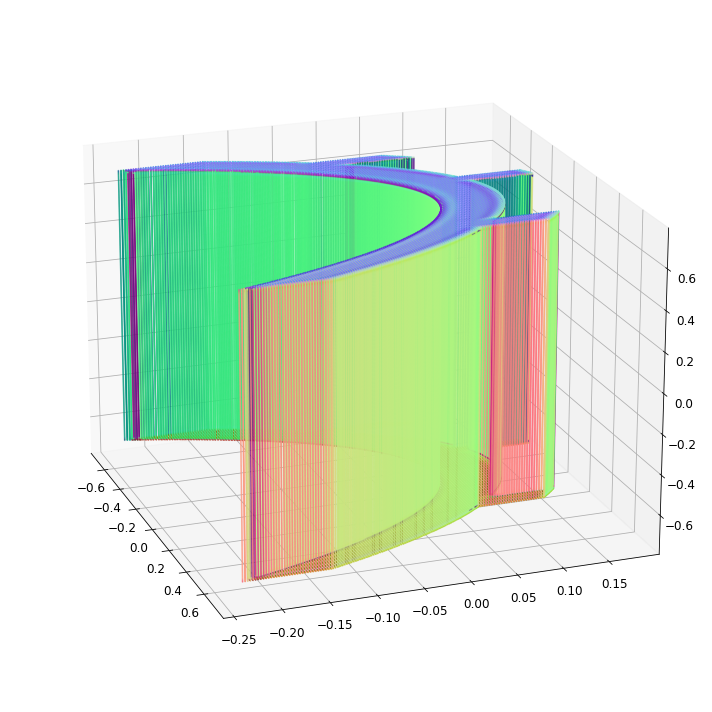

In [20]:
plt.figure(figsize=(20, 10))
# plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points, extracted from numpy array
# p = ax.scatter3D(x, y, z, c=z, cmap='winter', s = 5, alpha=0.6) # other cmap options: winter, Greens
ax.scatter3D(point_cloud_dataset.points[:, 0], 
             point_cloud_dataset.points[:, 1], 
             point_cloud_dataset.points[:, 2], c=color_n, s = 0.5, alpha=0.4) #cmap='winter'

# points_new = points_np_array[((points_np_array[:,2] > (z_mean-0.05))),:]
# x = points_new[:,0]
# y = points_new[:,1]
# z = points_new[:,2]
# ax.scatter3D(x, y, z, c = 'r', s = 1, alpha=0.2)
# cbar = plt.colorbar(p)
# cbar.ax.set_ticks(np.arange(0, 2, 0.5))

# cbar.set_label("Z Height (mm)", fontsize=16, labelpad=15)
# ax.set_xlabel('X (mm)', fontsize=25, labelpad=25)
# ax.set_ylabel('Y (mm)', fontsize=25,labelpad=25)
# ax.set_zlabel('Z (mm)', fontsize=25, labelpad=20);
# ax.set_zticks([0, 0.5, 1, 1.5, 2])
# ax.set_xticks([-20, -10, 0, 10, 20])
# ax.set_yticks([-30, -20, -10, 0, 10, 20, 30])

# for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(20)
# for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(20)
# for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(20)

# plt.title('3D Point cloud and reference plane')
ax.view_init(elev=20,azim=-20) #rotate the graph
# save_fig_plt("S_seg_normal")

Saving figure S_seg_curvature


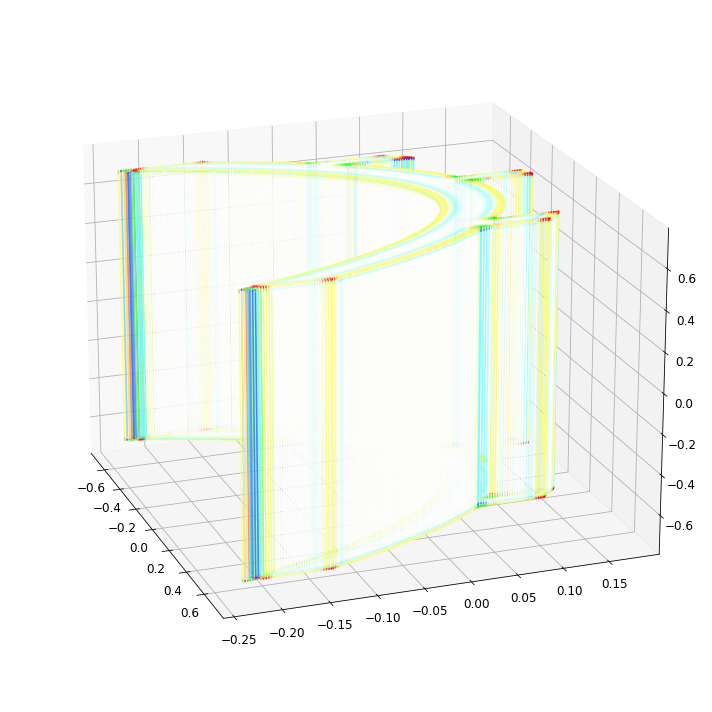

In [21]:
plt.figure(figsize=(20, 10))
# plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points, extracted from numpy array
# p = ax.scatter3D(x, y, z, c=z, cmap='winter', s = 5, alpha=0.6) # other cmap options: winter, Greens
ax.scatter3D(point_cloud_dataset.points[:, 0], 
             point_cloud_dataset.points[:, 1], 
             point_cloud_dataset.points[:, 2], c=color_curv, s = 0.5, alpha=0.4) #cmap='winter'

# points_new = points_np_array[((points_np_array[:,2] > (z_mean-0.05))),:]
# x = points_new[:,0]
# y = points_new[:,1]
# z = points_new[:,2]
# ax.scatter3D(x, y, z, c = 'r', s = 1, alpha=0.2)
# cbar = plt.colorbar(p)
# cbar.ax.set_ticks(np.arange(0, 2, 0.5))

# cbar.set_label("Z Height (mm)", fontsize=16, labelpad=15)
# ax.set_xlabel('X (mm)', fontsize=25, labelpad=25)
# ax.set_ylabel('Y (mm)', fontsize=25,labelpad=25)
# ax.set_zlabel('Z (mm)', fontsize=25, labelpad=20);
# ax.set_zticks([0, 0.5, 1, 1.5, 2])
# ax.set_xticks([-20, -10, 0, 10, 20])
# ax.set_yticks([-30, -20, -10, 0, 10, 20, 30])

# for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(20)
# for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(20)
# for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(20)

# plt.title('3D Point cloud and reference plane')
ax.view_init(elev=20,azim=-20) #rotate the graph
save_fig_plt("S_seg_curvature")

### Fit an n-jet using DeepFit (and compute normal vector and principal curvatures)
We first load the pretrained model and its parameters. 

In [ ]:
trained_model_path = '../DeepFit/trained_models/DeepFit'
params = torch.load(os.path.join(trained_model_path, 'DeepFit_params.pth'))
k_neighbors = params.points_per_patch #note you can use a different number, this is what the network trained on
jet_order = params.jet_order
print('Using {} order jet for surface fitting'.format(jet_order))
model = DeepFit.DeepFit(k=1, num_points=k_neighbors, use_point_stn=params.use_point_stn,
                        use_feat_stn=params.use_feat_stn, point_tuple=params.point_tuple, sym_op=params.sym_op,
                        arch=params.arch, n_gaussians=params.n_gaussians, jet_order=jet_order,
                        weight_mode=params.weight_mode, use_consistency=False)
checkpoint = torch.load(os.path.join(trained_model_path, 'DeepFit.pth'))
model.load_state_dict(checkpoint)
model.to(device)

#### Next we use DeepFit to fit a surface at each point in the point cloud. (Use the pre-trained model)
This may take a while, depending on the number of points. 

we also save the results into a txt file (.normal) and (.curv)

In [ ]:
dataloader = torch.utils.data.DataLoader(point_cloud_dataset, batch_size=128, num_workers=8)

num_batch = len(dataloader)

for batchind, data in enumerate(dataloader, 0):
    points = data[0]
    data_trans = data[1]
    scale_radius = data[-1].squeeze()
    points = points.to(device)
    data_trans = data_trans.to(device)
    scale_radius = scale_radius.to(device)
    n_est, beta, weights, trans, trans2, neighbors_n_est = model.forward(points)
    if params.use_point_stn:
        n_est = torch.bmm(n_est.unsqueeze(1), trans.transpose(2, 1)).squeeze(dim=1) # cancel out poitnnet stn
    # transform predictions with inverse pca rotation (back to world space)
    n_est = torch.bmm(n_est.unsqueeze(1), data_trans.transpose(2, 1)).squeeze(dim=1)  # cancel out pca
    # print('batchind and batch number[%d/%d]' % (batchind, num_batch-1))

    n_est = n_est.detach().cpu()
    normals = n_est if batchind == 0 else torch.cat([normals, n_est], 0)
    # ---------------------------Save estimated normals to file --------------------------------
    # eps=1e-6
    # normals[np.logical_and(normals < eps, normals > -eps)] = 0.0
    np.savetxt(os.path.join(file_output_dir + '/S_seg.normals'), normals)
    
    
    curv_est, principal_dirs = tu.compute_principal_curvatures(beta)
    curv_est = curv_est / scale_radius.unsqueeze(-1).repeat(1, curv_est.shape[1])
    curv_est = curv_est.detach().cpu()
    curvatures = curv_est if batchind == 0 else torch.cat([curvatures, curv_est], 0)
    
     # ---------------------------Save estimated normals to file --------------------------------
    np.savetxt(os.path.join(file_output_dir + '/S_seg.curv'), curvatures)
    

The normals are unoriented so we will now flip them outwards (assuming that the origin is an internal point and the shape is simple)

In [ ]:
n_sign = torch.sign(torch.sum(normals*torch.tensor(point_cloud_dataset.points), dim=1)).unsqueeze(-1)
normals = n_sign * normals
normals = normals.detach().cpu()
curvatures = n_sign.repeat([1, 2]) * curvatures

### Visualize the point cloud (DeepFit Network results)
We plot the point cloud and allow for 3 color overlays:
* Solid - (all points have the same color)
* Normals - We map the normal vectors to the RGB cube and use these values for coloring the point cloud.
* Curvatures - We map the principal curvatures to the XXX colormap to RGB. 

In [ ]:
color_n = tu.normal2rgb(normals.numpy()) #convert normal vectors to RGB
curvature_range_min = [-torch.mean(torch.abs(curvatures[:, 1])) - torch.std(torch.abs(curvatures[:, 1])), 
                                torch.mean(torch.abs(curvatures[:, 1])) + torch.std(torch.abs(curvatures[:, 1]))]
curvature_range_max = [-torch.mean(torch.abs(curvatures[:, 0])) - torch.std(torch.abs(curvatures[:, 0])), 
                                torch.mean(np.abs(curvatures[:, 0])) + torch.std(torch.abs(curvatures[:, 0]))]                                   
color_curv = tu.curvatures2rgb(curvatures.clone(),  k1_range=curvature_range_max, k2_range=curvature_range_min)

# make some buttons to toggle between the colors 
btn_pc = widgets.Button(description='Solid')
btn_pc.style.button_color='lightgray'
btn_n = widgets.Button(description='normals')
btn_n.style.button_color='lightgray'
btn_c = widgets.Button(description='Curvatures')
btn_c.style.button_color='lightgray'

def update_pc_color_to_solid(b, scatter_h):
    """    
        this function is linked to the buttons and updates the the point cloud color
    """
    scatter_h.color = 'red'

    
def update_pc_color_to_normal(b, scatter_h):
    """    
        this function is linked to the buttons and updates the the point cloud color
    """
    scatter_h.color = color_n

def update_pc_color_to_curv(b, scatter_h):
    """    
        this function is linked to the buttons and updates the the point cloud color
    """
    scatter_h.color = color_curv

#plot
fig_h = ipv.figure()
scatter_h = ipv.pylab.scatter(point_cloud_dataset.points[:, 0], 
                              point_cloud_dataset.points[:, 1], 
                              point_cloud_dataset.points[:, 2], size=0.5, marker="sphere", color='red')
ipv.pylab.xyzlim(-1, 1)
ipv.style.use('minimal')
# ipv.show()

btn_pc.on_click(functools.partial(update_pc_color_to_solid, scatter_h=scatter_h))
btn_n.on_click(functools.partial(update_pc_color_to_normal, scatter_h=scatter_h))
btn_c.on_click(functools.partial(update_pc_color_to_curv, scatter_h=scatter_h))
display(widgets.VBox((widgets.HBox((btn_pc, btn_n, btn_c)), fig_h)))

In [ ]:
plt.figure(figsize=(20, 10))
# plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points, extracted from numpy array
# p = ax.scatter3D(x, y, z, c=z, cmap='winter', s = 5, alpha=0.6) # other cmap options: winter, Greens
ax.scatter3D(point_cloud_dataset.points[:, 0], 
             point_cloud_dataset.points[:, 1], 
             point_cloud_dataset.points[:, 2], c=color_n, s = 0.5, alpha=0.4) #cmap='winter'

# points_new = points_np_array[((points_np_array[:,2] > (z_mean-0.05))),:]
# x = points_new[:,0]
# y = points_new[:,1]
# z = points_new[:,2]
# ax.scatter3D(x, y, z, c = 'r', s = 1, alpha=0.2)
# cbar = plt.colorbar(p)
# cbar.ax.set_ticks(np.arange(0, 2, 0.5))

# cbar.set_label("Z Height (mm)", fontsize=16, labelpad=15)
# ax.set_xlabel('X (mm)', fontsize=25, labelpad=25)
# ax.set_ylabel('Y (mm)', fontsize=25,labelpad=25)
# ax.set_zlabel('Z (mm)', fontsize=25, labelpad=20);
# ax.set_zticks([0, 0.5, 1, 1.5, 2])
# ax.set_xticks([-20, -10, 0, 10, 20])
# ax.set_yticks([-30, -20, -10, 0, 10, 20, 30])

# for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(20)
# for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(20)
# for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(20)

# plt.title('3D Point cloud and reference plane')
ax.view_init(elev=20,azim=-20) #rotate the graph
# save_fig_plt("S_seg_DeepFit")